In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import time
%matplotlib inline

#import wandb

#run = wandb.init()


In [3]:
#stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         #tt.RandomHorizontalFlip(), 
                         #tt.ToTensor()])

#train_tfms = tt.Compose([tt.ToTensor()])
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),tt.RandomHorizontalFlip(),tt.ToTensor(),tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats,inplace=True)])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_tfms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=valid_tfms)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 200
train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=3,pin_memory=True)
valid_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size*2,
                                         shuffle=False, num_workers=3,pin_memory=True)

In [4]:
def plot_rgb_histogram(dataloader, num_samples=1):
    # Initialize lists for each color channel
    red_values, green_values, blue_values = [], [], []

    # Iterate through the DataLoader to collect pixel values
    for images, labels in dataloader:
        # Extract RGB channels
        red_channel = images[:, 0, :, :].reshape(-1).numpy()
        green_channel = images[:, 1, :, :].reshape(-1).numpy()
        blue_channel = images[:, 2, :, :].reshape(-1).numpy()

        # Extend the lists with pixel values
        red_values.extend(red_channel)
        green_values.extend(green_channel)
        blue_values.extend(blue_channel)

        if len(red_values) >= num_samples:
            break

    # Plot histograms for each color channel
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.hist(red_values, bins=256, color='red', density=True)
    plt.title("Red Channel Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.subplot(132)
    plt.hist(green_values, bins=256, color='green', density=True)
    plt.title("Green Channel Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.subplot(133)
    plt.hist(blue_values, bins=256, color='blue', density=True)
    plt.title("Blue Channel Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()



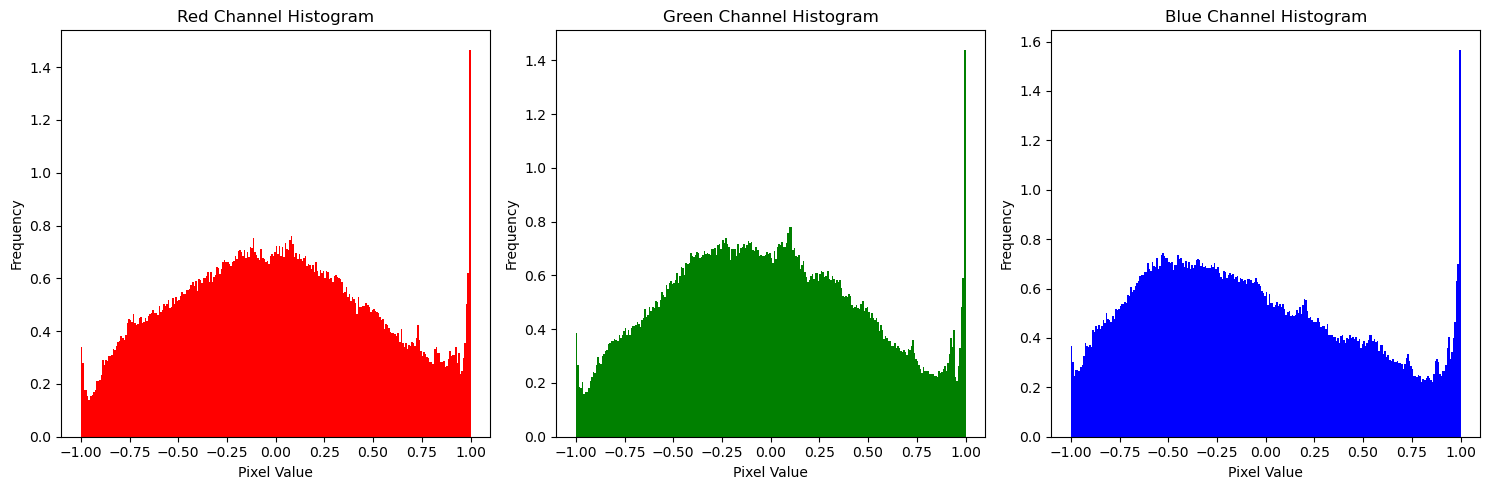

In [5]:
# Assuming train_dataloader is your DataLoader for the training set
plot_rgb_histogram(valid_dl)

In [6]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


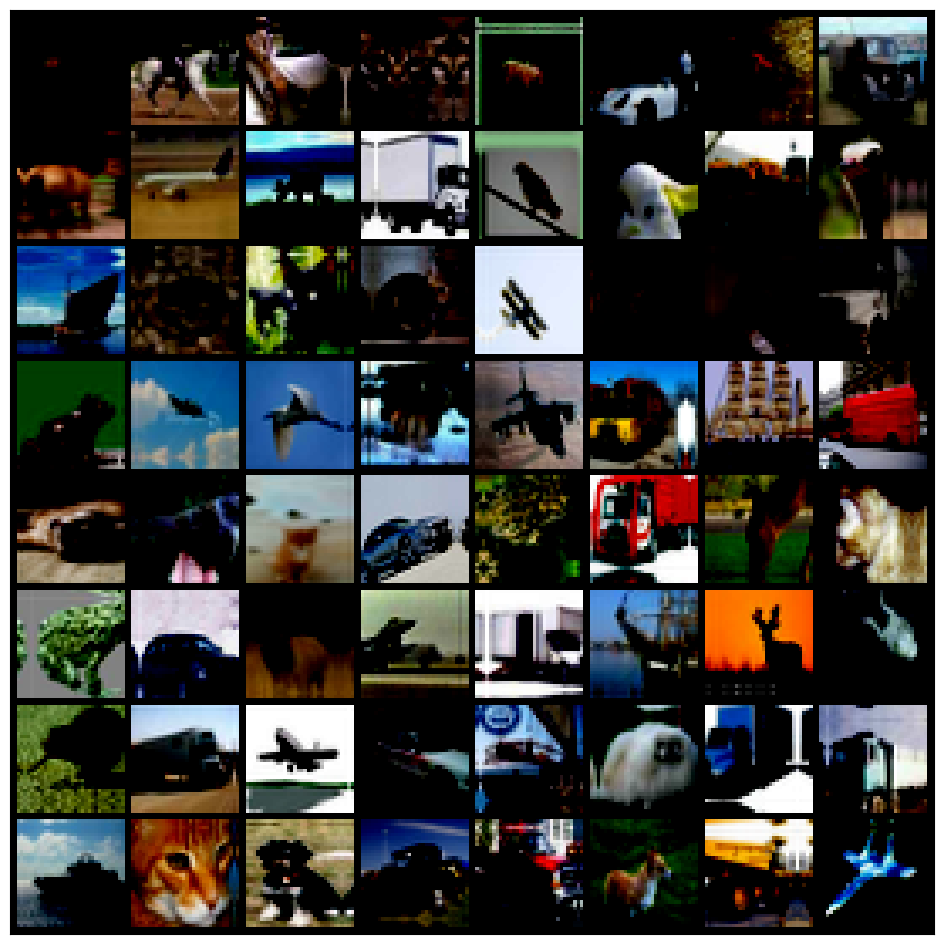

In [7]:
show_batch(train_dl)


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,bias=False), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class AddNoise(nn.Module):
    def __init__(self, mean=0, std=1):
        super(AddNoise, self).__init__()
        self.mean = mean
        self.std = std
    
    def to_device(self, device):
        # Move the internal state (mean and std) to the specified device
        self.mean = torch.tensor(self.mean, device=device)
        self.std = torch.tensor(self.std, device=device)
    
    def forward(self, x):
        noise = torch.randn(x.size(),device=device) * self.std + self.mean
        return x+noise


class Net1(nn.Module):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1,bias = False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.add_noise = AddNoise()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1,bias=False)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.res1 = nn.Sequential(conv_block(128, 128),conv_block(128, 128))
        self.res1conv1 = nn.Conv2d(128, 128, kernel_size=3, padding=1,bias=False)
        self.res1batchnorm1 = nn.BatchNorm2d(128)
        self.res1conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1,bias=False)
        self.res1batchnorm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1,bias=False)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.res2 = nn.Sequential(conv_block(512, 512),conv_block(512, 512))
        self.res2conv1 = nn.Conv2d(512, 512, kernel_size=3, padding=1,bias=False)
        self.res2batchnorm1 = nn.BatchNorm2d(512)
        self.res2conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1,bias=False)
        self.res2batchnorm2 = nn.BatchNorm2d(512)
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))        

        
    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = (x-torch.mean(x))/(torch.std(x))
        #x = self.add_noise(x)
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = (x-torch.mean(x))/(torch.std(x))
        #x = self.add_noise(x)
        y = x
        x = F.relu(self.res1batchnorm1(self.res1conv1(x)))
        x = (x-torch.mean(x))/(torch.std(x))
        #x = self.add_noise(x)
        x = F.relu(self.res1batchnorm2(self.res1conv2(x)))
        x = (x-torch.mean(x))/(torch.std(x))
        #x = self.add_noise(x)
        x = x+y
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = (x-torch.mean(x))/(torch.std(x))
        #x = self.add_noise(x)
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = (x-torch.mean(x))/(torch.std(x))
        #x = self.add_noise(x)
        z = x
        x = F.relu(self.res2batchnorm1(self.res2conv1(x)))
        x = (x-torch.mean(x))/(torch.std(x))
        #x = self.add_noise(x)
        x = F.relu(self.res2batchnorm2(self.res2conv2(x)))
        x = (x-torch.mean(x))/(torch.std(x))
        #x = self.add_noise(x)
        x = x+z
        x = self.classifier(x)
        return x
        
    
class Net2(nn.Module):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1,bias = False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.add_noise = AddNoise()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1,bias=False)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.res1 = nn.Sequential(conv_block(128, 128),conv_block(128, 128))
        self.res1conv1 = nn.Conv2d(128, 128, kernel_size=3, padding=1,bias=False)
        self.res1batchnorm1 = nn.BatchNorm2d(128)
        self.res1conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1,bias=False)
        self.res1batchnorm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1,bias=False)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.res2 = nn.Sequential(conv_block(512, 512),conv_block(512, 512))
        self.res2conv1 = nn.Conv2d(512, 512, kernel_size=3, padding=1,bias=False)
        self.res2batchnorm1 = nn.BatchNorm2d(512)
        self.res2conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1,bias=False)
        self.res2batchnorm2 = nn.BatchNorm2d(512)
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))        

        
    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = (x-torch.mean(x))/(torch.std(x))
        x = self.add_noise(x)
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = (x-torch.mean(x))/(torch.std(x))
        x = self.add_noise(x)
        y = x
        x = F.relu(self.res1batchnorm1(self.res1conv1(x)))
        x = (x-torch.mean(x))/(torch.std(x))
        x = self.add_noise(x)
        x = F.relu(self.res1batchnorm2(self.res1conv2(x)))
        x = (x-torch.mean(x))/(torch.std(x))
        x = self.add_noise(x)
        x = x+y
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = (x-torch.mean(x))/(torch.std(x))
        x = self.add_noise(x)
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = (x-torch.mean(x))/(torch.std(x))
        x = self.add_noise(x)
        z = x
        x = F.relu(self.res2batchnorm1(self.res2conv1(x)))
        x = (x-torch.mean(x))/(torch.std(x))
        x = self.add_noise(x)
        x = F.relu(self.res2batchnorm2(self.res2conv2(x)))
        x = (x-torch.mean(x))/(torch.std(x))
        x = self.add_noise(x)
        x = x+z
        x = self.classifier(x)
        return x

net1 = Net1(3,10)
net2 = Net2(3,10)
net1 = net1.to(device)
net2 = net2.to(device)


In [10]:
#load the pretrained weights for clean network 
#net1.load_state_dict(torch.load('teacher_30epochs_pre.pth'))
#net2.load_state_dict(torch.load('teacher_30epochs_pre.pth'))

<All keys matched successfully>

In [8]:
net1.load_state_dict(torch.load('gaussian_std1_net1.pth'))
net2.load_state_dict(torch.load('gaussian_std1_net2.pth'))

<All keys matched successfully>

In [11]:
for param in net1.parameters():
    param.requires_grad = False

In [12]:
epochs = 30
max_lr = 0.0005
#lrtest = 0.005
grad_clip = 0.1
weight_decay = 1e-4

In [13]:
import torch.optim as optim

criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()
criterion3 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(net2.parameters(), lr=max_lr, weight_decay = weight_decay)
#optimizer2 = optim.Adam(net2.parameters(), lr=max_lr, weight_decay = weight_decay)
scheduler2 = optim.lr_scheduler.OneCycleLR(optimizer2, max_lr, epochs=epochs,steps_per_epoch=len(train_dl))
#scheduler2 = optim.lr_scheduler.OneCycleLR(optimizer2, max_lr, epochs=epochs, pct_start=0.1,  
                                                #steps_per_epoch=len(train_dl))

In [14]:
def val_loss():
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valid_dl:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            #outputs,activations = net.inference_with_noise(images)
            outputs = net2(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Val acc of the network on the 10000 test images: {100. * correct / total:.2f} %')
    return correct / total

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

T = 6
training_time = 0
alpha = 0


for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.perf_counter()
    
    running_loss = 0.0
    running_loss1 = 0.0
    running_loss2 = 0.0
    running_loss3 = 0.0
    lrs = []
    correct_predictions = 0
    total_predictions = 0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #set mirror net2 parameters to net1
        #net2.load_state_dict(net1.state_dict())
        # zero the parameter gradients
        optimizer2.zero_grad()
        #optimizer2.zero_grad()

        # forward + backward + optimize
        outputs1 = net1(inputs)
        outputs1_prob = F.softmax(outputs1/T, dim=1)
        outputs2 = net2(inputs)
        outputs2_prob = F.softmax(outputs2, dim=1)
        outputs2_prob_T = F.softmax(outputs2/T, dim=1)
        
        loss_student_hard = criterion1(outputs2_prob, labels)
        loss_student_soft = criterion2(outputs2_prob_T, outputs1_prob)
        loss =loss_student_hard+alpha*(T**2)*(loss_student_soft)
        run.log({
            "loss/total": loss,
            "loss/hard": loss_student_hard,
            "loss/soft": loss_student_soft,
        })
        loss.backward()
        nn.utils.clip_grad_value_(net2.parameters(), grad_clip)

        optimizer2.step()
        #optimizer2.step()
        lrs.append(get_lr(optimizer2))
        scheduler2.step()

        
        # Calculate training accuracy
        _, predicted = torch.max(outputs2, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        training_acc = (correct_predictions/total_predictions)*100
        run.log({
            "training_acc": training_acc,
        })

        # print statistics
        running_loss += loss.item()
        running_loss1 += loss_student_hard.item()
        running_loss2 += loss_student_soft.item()
        #running_loss3 += loss3.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f} learning rate: {lrs[i]} training accuracy: {training_acc:.3f}')
            print(f'[{epoch + 1}, {i + 1:5d}] loss_hard: {running_loss1 / 50:.3f} loss_soft: {running_loss2 / 50:.3f}')
            #print(f'[{epoch + 1}, {i + 1:5d}] loss1: {running_loss1 / 50:.3f} loss2: {running_loss2 / 50:.3f} loss3: {running_loss3 / 50:.3f}')
            running_loss = 0.0
            running_loss1 = 0.0
            running_loss2 = 0.0
            running_loss3 = 0.0
            run.log({
                "val_acc": val_loss(),
                })
            
    training_time += time.perf_counter()-start_time

print(f'Finished Training, Training time: {training_time}')



/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


[1,    50] loss: 1.698 learning rate: 2.056198493911068e-05 training accuracy: 78.420
[1,    50] loss_hard: 1.698 loss_soft: 2.085
Val acc of the network on the 10000 test images: 78.54 %
[1,   100] loss: 1.663 learning rate: 2.2291290839822353e-05 training accuracy: 80.160
[1,   100] loss_hard: 1.663 loss_soft: 2.074
Val acc of the network on the 10000 test images: 80.52 %
[1,   150] loss: 1.650 learning rate: 2.5179719361005345e-05 training accuracy: 81.090
[1,   150] loss_hard: 1.650 loss_soft: 2.060
Val acc of the network on the 10000 test images: 81.07 %
[1,   200] loss: 1.648 learning rate: 2.921318585742997e-05 training accuracy: 81.570
[1,   200] loss_hard: 1.648 loss_soft: 2.057
Val acc of the network on the 10000 test images: 81.68 %
[1,   250] loss: 1.629 learning rate: 3.437202221398425e-05 training accuracy: 82.284
[1,   250] loss_hard: 1.629 loss_soft: 2.041
Val acc of the network on the 10000 test images: 81.98 %
[2,    50] loss: 1.624 learning rate: 4.0631072751949604e-

In [44]:

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
acc_list = []

for i in range(25):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valid_dl:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            #outputs,activations = net.inference_with_noise(images)
            outputs = net2(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
        acc_list.append(100*correct/total)

        
#print(acc_list.shape)           

#print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of the network on the 10000 test images: 92.46 %
Accuracy of th

In [45]:
print(np.mean(acc_list))
print(np.std(acc_list))

92.46
0.0


After clipping:
Min value: -1.0982412099838257
Max value: 1.0685721635818481


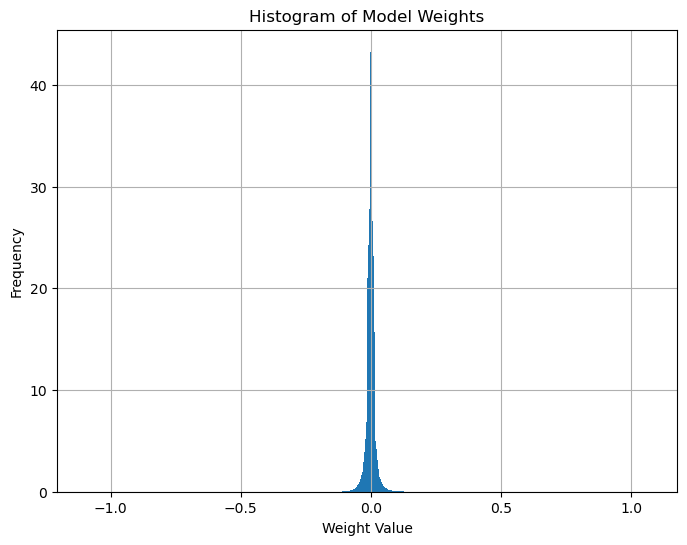

After Percentile:
lower_bound: -0.02623093267902732
upper_bound: 0.024081034399568997
mean: -0.00022941068
std: 0.022275308


In [18]:
# Function to calculate min-max statistics of model parameters
def calculate_min_max(model):
    min_value = float('inf')
    max_value = float('-inf')
    for param in model.parameters():
        if param.requires_grad:
            min_value = min(min_value, param.data.min().item())
            max_value = max(max_value, param.data.max().item())
    return min_value, max_value

                
# Function to clip weights based on percentiles
def clip_weights_by_percentiles(model, lower_percentile=5, upper_percentile=95):
    all_weights = np.concatenate([param.data.cpu().numpy().flatten() for param in model.parameters() if param.requires_grad])
    lower_bound = np.percentile(all_weights, lower_percentile)
    upper_bound = np.percentile(all_weights, upper_percentile)
    w_mean = np.mean(all_weights)
    w_std = np.std(all_weights)
    
    plt.figure(figsize=(8, 6))
    plt.hist(all_weights, bins=1000, density=True)
    plt.title('Histogram of Model Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    #with torch.no_grad():
        #for param in model.parameters():
           # if param.requires_grad:
              #  param.data.clamp_(min=lower_bound, max=upper_bound)
    
    return lower_bound, upper_bound, w_mean, w_std

# Example usage
# Assuming you have a trained model called 'model'
min_val, max_val = calculate_min_max(net2)
print("After clipping:")
print("Min value:", min_val)
print("Max value:", max_val)

lower_bound, upper_bound, w_mean, w_std = clip_weights_by_percentiles(net2)
print("After Percentile:")
print("lower_bound:",lower_bound)
print("upper_bound:", upper_bound)
print("mean:",w_mean)
print("std:",w_std)



In [12]:
#Performing jpeg distortion 

from PIL import Image
import torchvision.transforms.functional as TF
from io import BytesIO
import random

def randomJPEGcompression(image):
    qf = 20
    outputIoStream = BytesIO()
    image.save(outputIoStream, "JPEG", quality=qf, optimice=True)
    outputIoStream.seek(0)
    return Image.open(outputIoStream)

#tt.RandomHorizontalFlip()
valid_tfms_1 = tt.Compose([tt.Lambda(randomJPEGcompression), 
                           tt.ToTensor(), tt.Normalize(*stats,inplace=True)])
valid_tfms_2 = tt.Compose([tt.ToTensor(), tt.Normalize(*stats,inplace=True), AddGaussianNoise()])
testset_1 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=valid_tfms_1)

valid_dl_1 = torch.utils.data.DataLoader(testset_1, batch_size=batch_size*2,
                                         shuffle=False, num_workers=3,pin_memory=True)


Files already downloaded and verified


In [13]:
#Classifying distorted images

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_dl_1:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        #outputs,activations = net.inference_with_noise(images)
        outputs = net2(images)
    
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
            

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 68.00 %


In [25]:
#Saving the weights after pretraining for clean network 

#torch.save(net1.state_dict(), 'gaussian_std1_net1.pth')
#torch.save(net2.state_dict(), 'gaussian_std1_net2.pth')

In [22]:
#load the pretrained weights for clean network 
net1.load_state_dict(torch.load('gaussian_std1_net1.pth'))
net2.load_state_dict(torch.load('gaussian_std1_net2.pth'))

In [23]:
for layer_name, activation_map in activations.items():
    if len(activation_map.shape) == 4:  # Assuming activations are in the format (batch_size, channels, height, width)
        plt.figure(figsize=(8, 8))
        num_channels = activation_map.shape[1]
        for i in range(5):
            plt.subplot(1,5, i + 1)
            plt.imshow(activation_map[0, i, :, :], cmap='viridis')
            plt.colorbar()
            plt.title(f'Channel {i}')
            plt.axis('off')
        plt.suptitle(f'Activations of {layer_name}')
        plt.show()

NameError: name 'activations' is not defined